In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_transformer

from matplotlib import pyplot as plt
%matplotlib inline


Interpreting linear models
==========================

Take home message: Linear models are not that easy to interpret when variables are
correlated.

Data on wages
--------------

We first download and load some historical data on wages



In [16]:
# Download the data if it does not exists
if not os.path.exists('wages.txt'):
    from urllib.request import urlretrieve
    # Download the file if it is not present
    urlretrieve('http://lib.stat.cmu.edu/datasets/CPS_85_Wages',
                'wages.txt')

# Give names to the columns
names = [
    'EDUCATION: Number of years of education',
    'SOUTH: 1=Person lives in South, 0=Person lives elsewhere',
    'SEX: 1=Female, 0=Male',
    'EXPERIENCE: Number of years of work experience',
    'UNION: 1=Union member, 0=Not union member',
    'WAGE: Wage (dollars per hour)',
    'AGE: years',
    'RACE: 1=Other, 2=Hispanic, 3=White',
    'OCCUPATION: 1=Management, 2=Sales, 3=Clerical, 4=Service, 5=Professional, 6=Other',
    'SECTOR: 0=Other, 1=Manufacturing, 2=Construction',
    'MARR: 0=Unmarried,  1=Married',
]

short_names = [n.split(':')[0] for n in names]
data = pd.read_csv(
    'wages.txt', skiprows=27, skipfooter=6, sep=None,
    header=None, engine='python'
)
data.columns = short_names

# Log-transform the wages, as they typically increase with
# multiplicative factors
data['WAGE'] = np.log10(data['WAGE'])

The challenge of correlated features
--------------------------------------------

Plot scatter matrices highlighting the links between different
variables measured



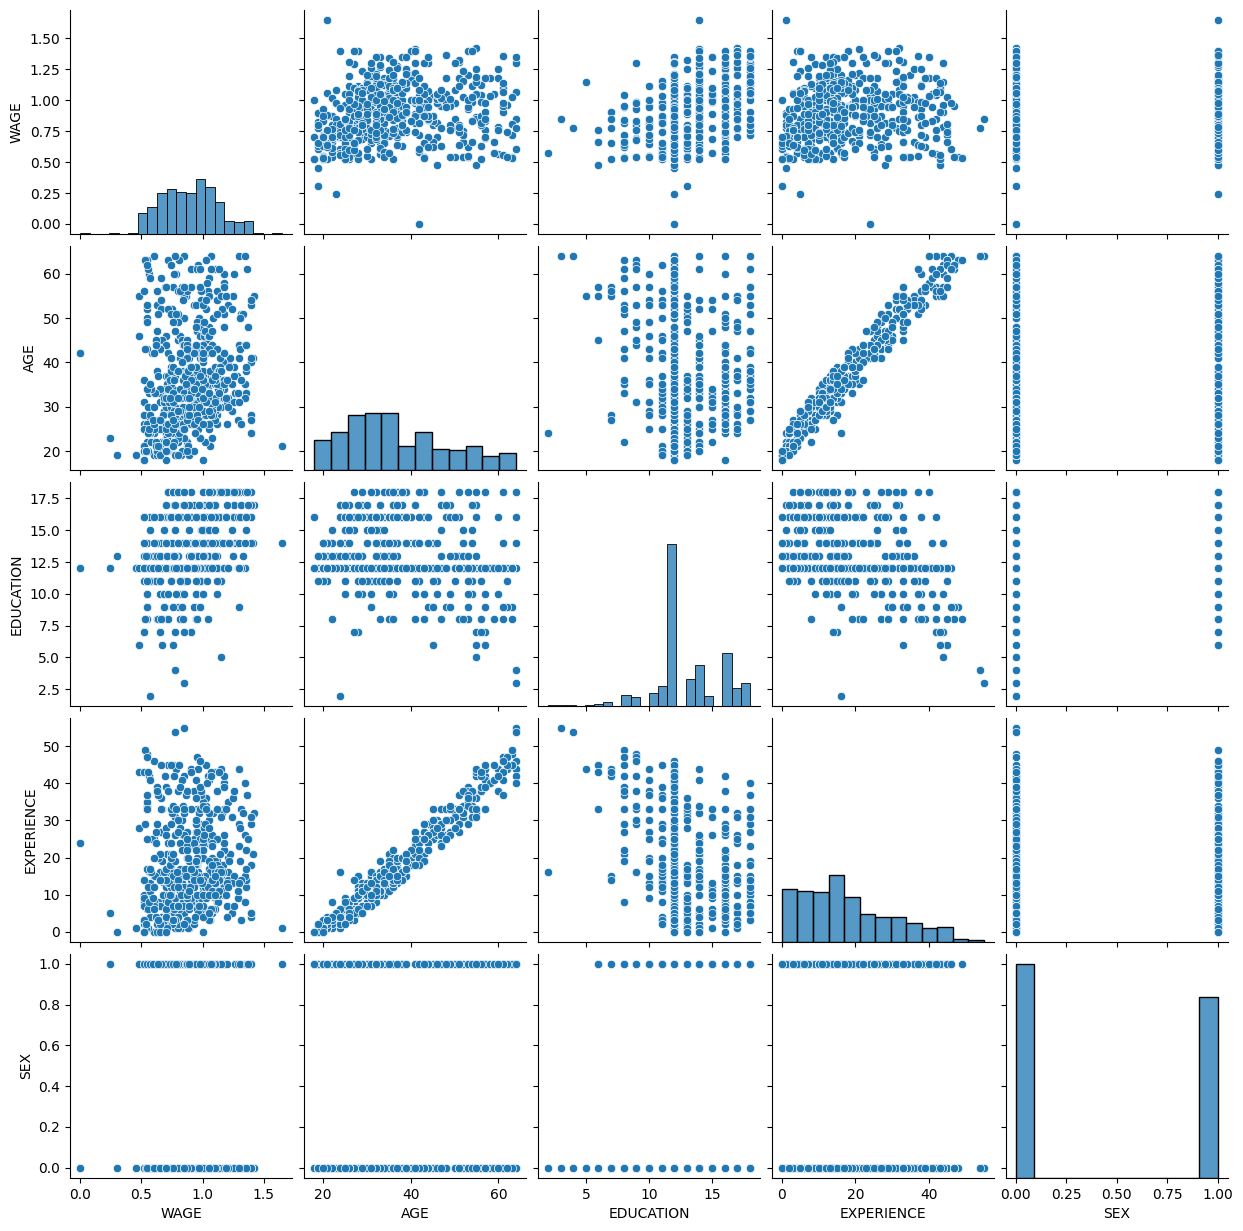

In [17]:
# The simplest way to plot a pairplot
sns.pairplot(
    data,
    vars=['WAGE', 'AGE', 'EDUCATION', 'EXPERIENCE', 'SEX']
)

A fancier pair plot



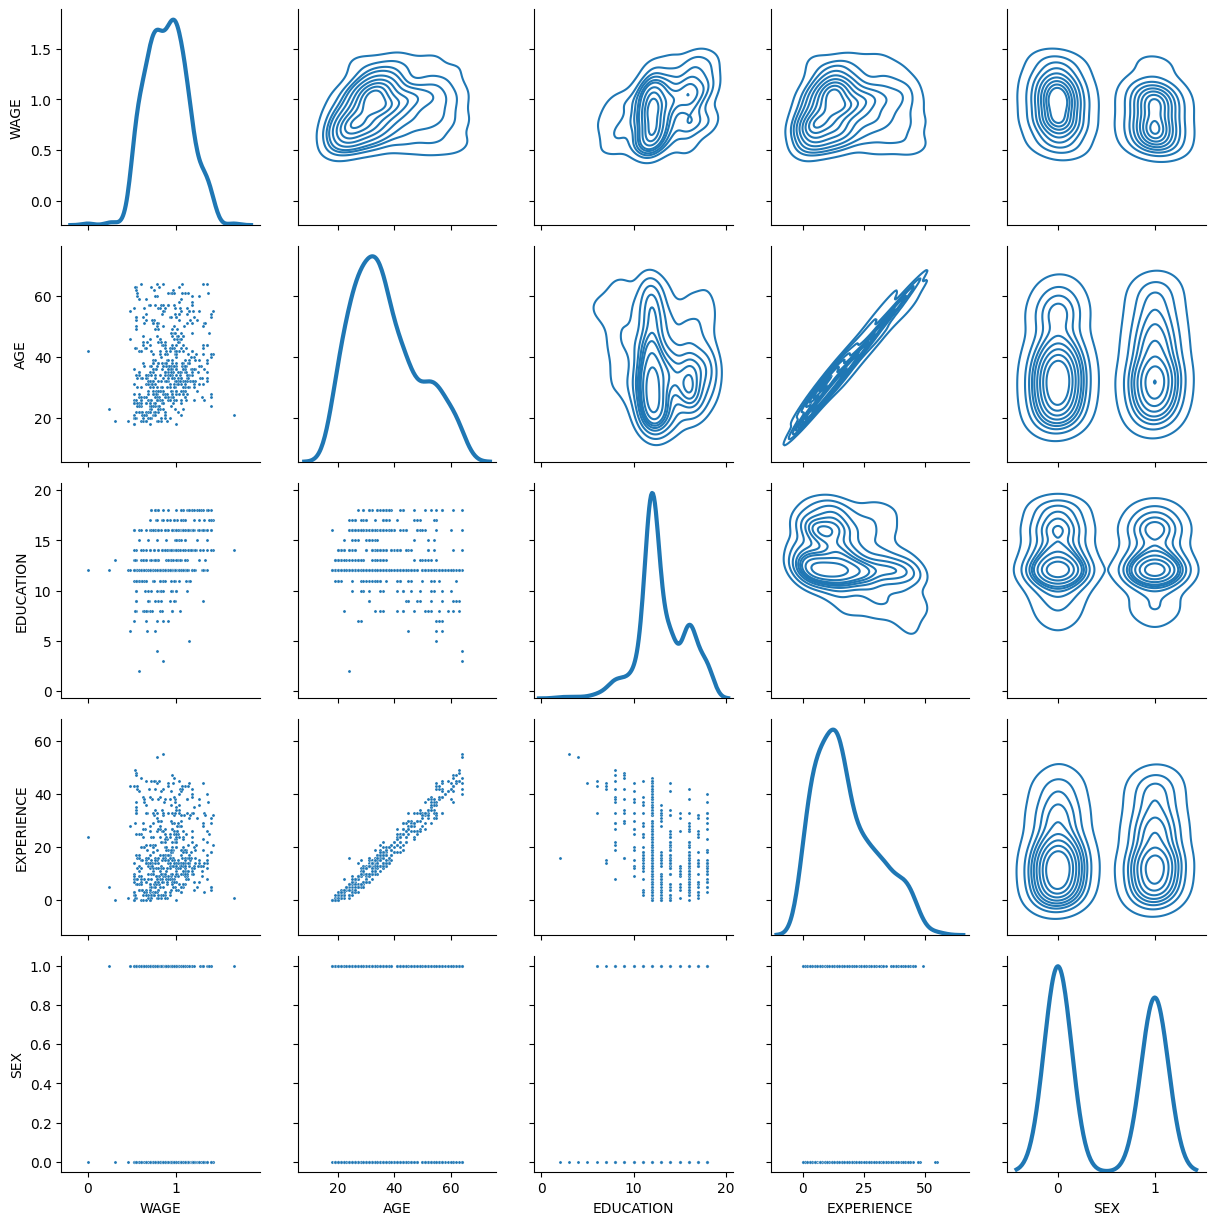

In [4]:
g = sns.PairGrid(
    data,
    vars=['WAGE', 'AGE', 'EDUCATION', 'EXPERIENCE', 'SEX'],
    diag_sharey=False
)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot, s=5)
g.map_diag(sns.kdeplot, lw=3)

Note that age and experience are highly correlated

A link between a single feature and the target is a **marginal** link.


Univariate feature selection selects on marginal links.

Linear model compute **conditional** links: removing the effects of other
features on each feature. This is hard when features are correlated.



In [20]:
X = data.drop(columns=['WAGE'] + ['RACE', 'OCCUPATION', 'SECTOR'])
y = data['WAGE']

Coefficients of a linear model
--------------------------------------------




In [21]:
ridge = linear_model.RidgeCV()
ridge.fit(X, y)

RidgeCV()

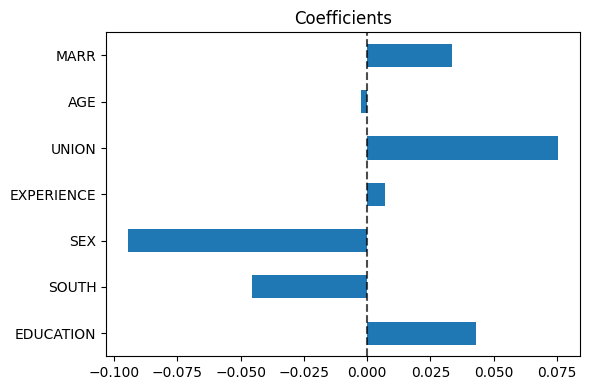

In [23]:
# Visualize the coefs
plt.figure(figsize=(6, 4))

coefs = pd.Series(ridge.coef_, index=X.columns)
coefs.plot(kind='barh')
plt.axvline(0., color='k', linestyle='--', alpha=0.7)

plt.title("Coefficients")
plt.tight_layout()

**Scaling coefficients**: coefs cannot easily be compared if X is not
standardized: they should be normalized to the variance of X: the
greater the variance of a feature, the large the impact of the
corresponding coefficent on the output.

If the different features have differing, possibly arbitrary, scales,
then scaling the coefficients by the feature scale often helps
interpretation.



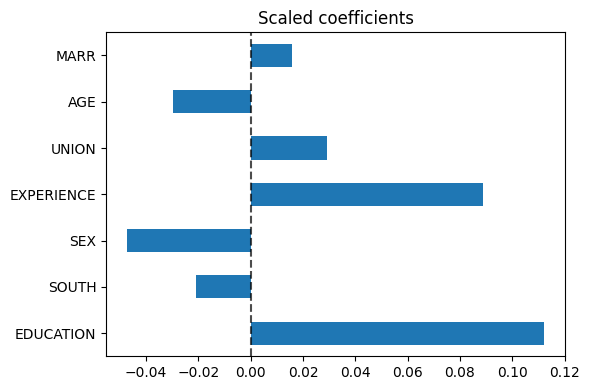

In [8]:
X_std = X.std()
plt.figure(figsize=(6, 4))
(X_std * coefs).plot(kind='barh')
plt.axvline(0., color='k', linestyle='--', alpha=0.7)
plt.title("Scaled coefficients")
plt.tight_layout()

Now the age and experience can be better compared: and experience does
appear as more important than age.



<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Redo the same analysis after removing education from the set of variables. How does it affect the coefficient associated to age? Do you see anything surprising? Can you interpret this?</li>
</ul>
</div>

Solution: `solutions/01-no_edu.py`

The effect of regularization
--------------------------------------------

Sparse models use l1 regularization to puts some variables to
zero. This can often help interpretation



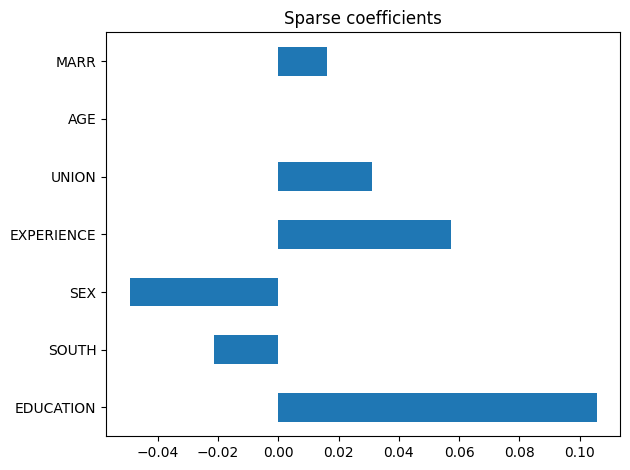

In [24]:
lasso = linear_model.LassoCV(max_iter=100_000, cv=5)
lasso.fit(X, y)

coefs = pd.Series(lasso.coef_, index=X.columns)
(X_std * coefs).plot(kind='barh')

plt.title("Sparse coefficients")
plt.tight_layout()

When two variables are very correlated (such as age and experience), it
will put arbitrarily one or the other to zero depending on their SNR.

Here we can see that experience probably overshadowed age.



Stability to gauge significance
--------------------------------

Stability of coefficients when perturbing the data helps giving an
informal evaluation of the significance of the coefficients. Note that
this is not significance testing in the sense of p-values, as a model
that returns coefficients always at one indepently of the data will
appear as very stable though it clearly does not control for false
detections.

We can do this in a cross-validation loop, using the argument
"return_estimator" of `sklearn.model_selection.cross_validate`
which has been added in version 0.20 of scikit-learn:

### With the lasso estimator




In [25]:
cv_lasso = cross_validate(lasso, X, y, return_estimator=True, cv=10)

In [26]:
coefs_ = [estimator.coef_ for estimator in cv_lasso['estimator']]

Plot the results with seaborn:



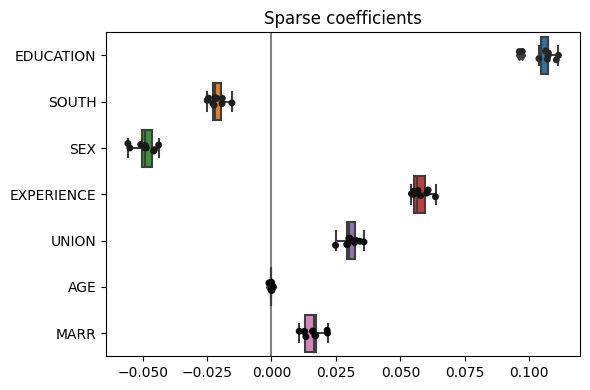

In [27]:
coefs_ = pd.DataFrame(coefs_, columns=X.columns) * X_std
plt.figure(figsize=(6, 4))
sns.boxplot(data=coefs_, orient='h')
sns.stripplot(data=coefs_, orient='h', palette='dark:k')
plt.axvline(x=0, color='.5')  # Add a vertical line at 0
plt.title('Sparse coefficients')
plt.tight_layout()

### With the ridge estimator


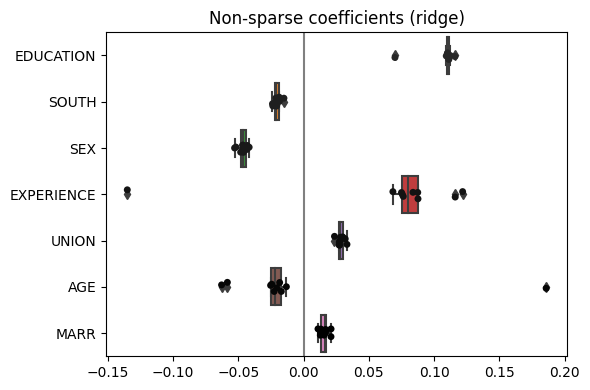

In [28]:
cv_ridge = cross_validate(ridge, X, y, return_estimator=True, cv=10)
coefs_ = [estimator.coef_ for estimator in cv_ridge['estimator']]

coefs_ = pd.DataFrame(coefs_, columns=X.columns) * X_std
plt.figure(figsize=(6, 4))
sns.boxplot(data=coefs_, orient='h')
sns.stripplot(data=coefs_, orient='h', palette='dark:k')
plt.axvline(x=0, color='.5') # Add a vertical line at 0
plt.title('Non-sparse coefficients (ridge)')
plt.tight_layout()

### Which is the truth?


Note the difference between the lasso and the ridge estimator: we do
not have enough data to perfectly estimate conditional relationships,
hence the prior (ie the regularization) makes a difference, and its is
hard to tell from the data which is the "truth".

One reasonnable model-selection criterion is to believe most the model
that predicts best. For this, we can inspect the prediction scores
obtained via the cross-validation



Text(0.5, 1.0, 'Model comparison')

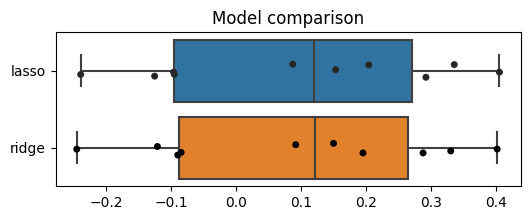

In [29]:
scores = pd.DataFrame({
    'lasso': cv_lasso['test_score'],
    'ridge': cv_ridge['test_score']
})
plt.figure(figsize=(6, 2))
sns.boxplot(data=scores, orient='h')
sns.stripplot(data=scores, orient='h', palette='dark:k')
plt.title("Model comparison")

Note also that the limitations of cross-validation explained previously
still apply. Ideally, we should use a ShuffleSplit cross-validation
object to sample many times and have a better estimate of the
posterior, both for the coefficients and the test scores.

#### Conclusion on factors of wages?


As always, concluding is hard. That said, it seems that we should
prefer the scaled ridge coefficients.

Hence, the most important factors of wage are education and
experience, followed by sex: at the same education and experience
females earn less than males. Note that this last statement is a
statement about the link between wage and sex, conditional on education
and experience.
